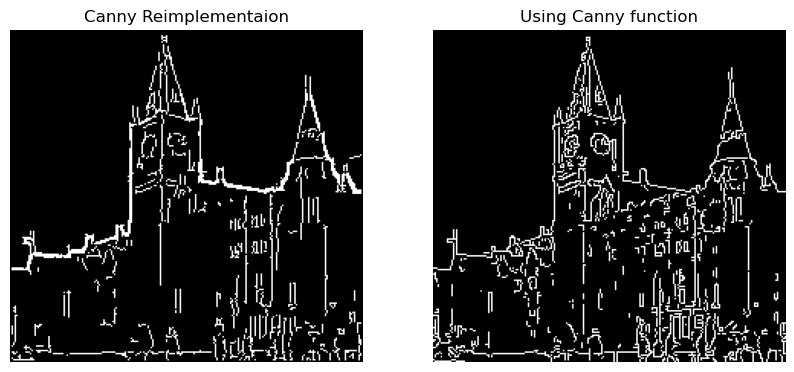

In [1]:
# Task1

# Part1: Reimplement the canny operation without using the built-in canny() function 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load greyscale image
image = cv2.imread('image/victoria1.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    print("Image loading failed, please check the path!")
    exit()

# Step 1: Noise Reduction
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Step 2: Gradient calculation with Sobel
sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
#gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
#gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)
gradient_magnitude = cv2.convertScaleAbs(np.abs(sobelx) + np.abs(sobely))

gradient_direction = np.arctan2(sobely, sobelx) * (180 / np.pi) # Convert to degrees

# Step 3: Non-maximum suppression
def non_maximum_suppression(gradient_magnitude, gradient_direction):
    h, w = gradient_magnitude.shape
    suppressed = np.zeros((h, w), dtype=np.uint8)
    
    angle = gradient_direction % 180 # Normalize angles to [0, 180)
    for i in range(1, h-1):
        for j in range(1, w-1):
            q, r = 255, 255
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180): # horizontal
                q, r = gradient_magnitude[i, j+1], gradient_magnitude[i, j-1]
            elif 22.5 <= angle[i, j] < 67.5: # 45°
                q, r = gradient_magnitude[i+1, j-1], gradient_magnitude[i-1, j+1]
            elif 67.5 <= angle[i, j] < 112.5: # vertical
                q, r = gradient_magnitude[i+1, j], gradient_magnitude[i-1, j]
            elif 112.5 <= angle[i, j] < 157.5: # 135°
                q, r = gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]
            
            # Keep the pixel if it is a local maximum
            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed[i, j] = gradient_magnitude[i, j]

    return suppressed

suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)

# Step 4: Double threshold process

# Classify edges into strong, weak, and non-relevant based on two thresholds
def double_threshold(suppressed_image, low_threshold, high_threshold):
    strong = 255  # Make sure all strong edges are set to 255
    weak = 75    # Temporary value for weak edges; make it distinct for debugging
    result = np.zeros_like(suppressed_image, dtype=np.uint8)

    # Identify strong and weak edge pixels
    strong_i, strong_j = np.where(suppressed_image >= high_threshold)
    weak_i, weak_j = np.where((suppressed_image >= low_threshold) & (suppressed_image < high_threshold))

    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak
    return result

thresholded_image = double_threshold(suppressed_image, 75, 120)

# Step 5: Edge Tracking by Hysteresis

# Ensures that weak edges connected to strong edges are retained
def edge_tracking_by_hysteresis(image, weak=75, strong=255):
    h, w = image.shape
    from collections import deque
    queue = deque([])  # Queue to process strong edges

    # Add all strong edges to the queue
    for i in range(1, h-1):
        for j in range(1, w-1):
            if image[i, j] == strong:
                queue.append((i, j))

    # Process queue to transform connected weak edges to strong edges
    while queue:
        i, j = queue.popleft()
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                ni, nj = i + di, j + dj
                if image[ni, nj] == weak:
                    image[ni, nj] = strong
                    queue.append((ni, nj))

    # Set any remaining weak edges to 0 to clear them from the image
    image[image == weak] = 0

    return image



final_edges = edge_tracking_by_hysteresis(thresholded_image)

# Using cv2.canny() function
edges_func = cv2.Canny(image, 150, 200)

# Display the final edge-detected image
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(final_edges, cmap='gray')
plt.title('Canny Reimplementaion')
plt.axis('off')

plt.subplot(122)
plt.imshow(edges_func, cmap='gray')
plt.title('Using Canny function'), 
plt.axis('off')
plt.show()



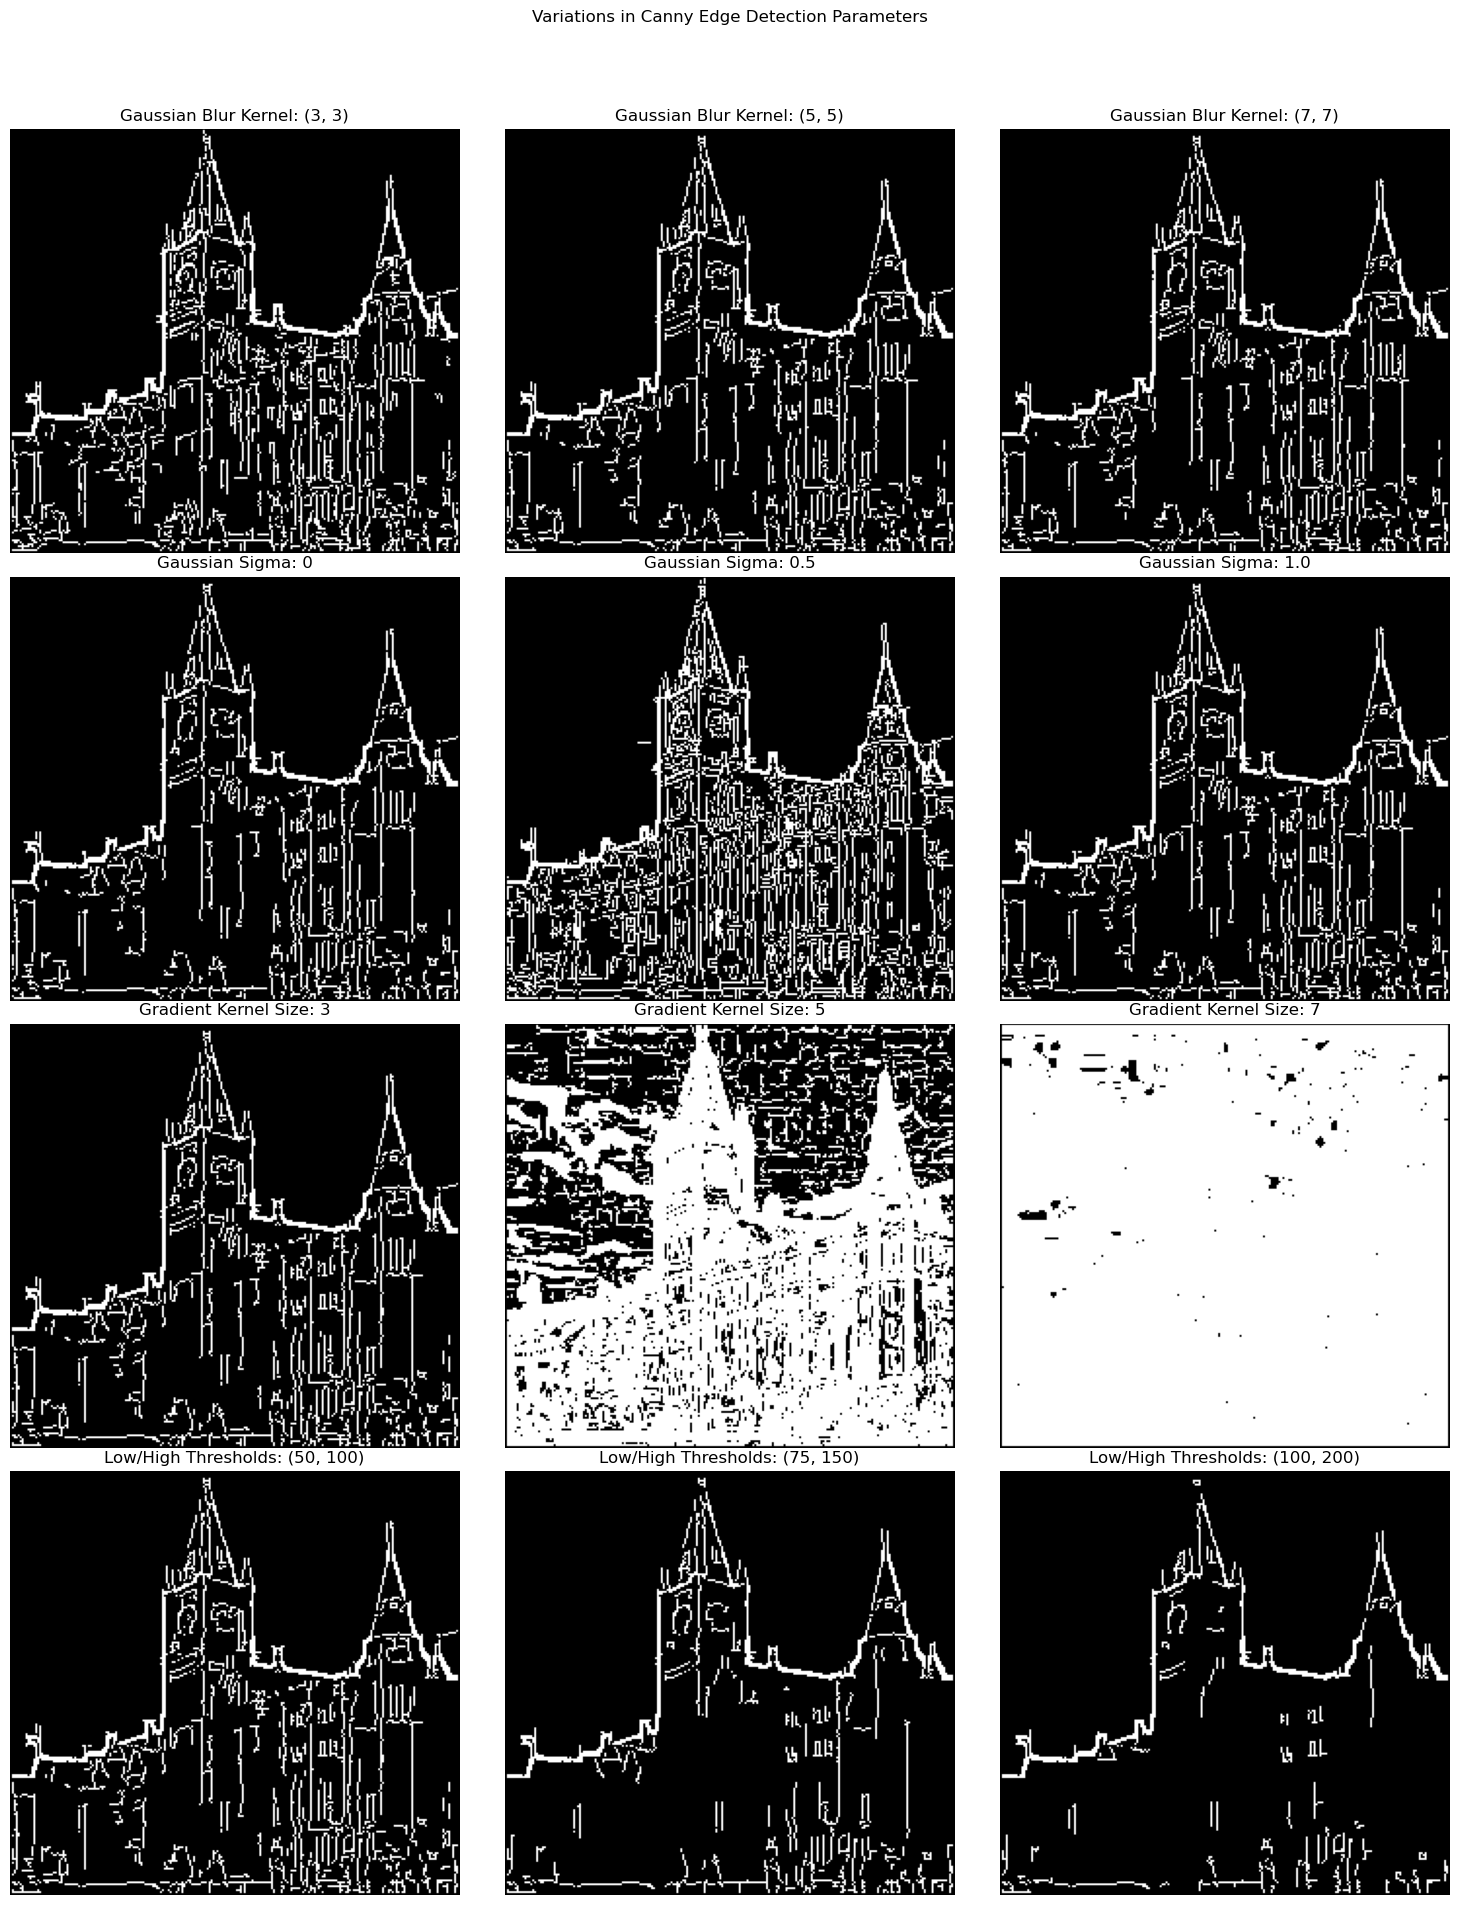

In [2]:
# Part 2: Test and visualize implementation results

def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

def apply_gaussian_blur(image, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def compute_gradients(image, ksize=3):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
    gradient_magnitude = cv2.convertScaleAbs(np.abs(sobelx) + np.abs(sobely))
    gradient_direction = np.arctan2(sobely, sobelx) * (180 / np.pi)  # Convert to degrees
    return gradient_magnitude, gradient_direction

# Wrapping a function for modifying parameters
def canny_custom(image_path, blur_kernel_size=(5, 5), blur_sigma=0, grad_ksize=3, low_threshold=75, high_threshold=100):
    image = load_image(image_path)
    if image is None:
        print("Image loading failed, please check the path!")
        return None

    blurred_image = apply_gaussian_blur(image, blur_kernel_size, blur_sigma)
    gradient_magnitude, gradient_direction = compute_gradients(blurred_image, grad_ksize)
    suppressed_image = non_maximum_suppression(gradient_magnitude, gradient_direction)
    thresholded_image = double_threshold(suppressed_image, low_threshold, high_threshold)
    final_edges = edge_tracking_by_hysteresis(thresholded_image)
    return final_edges

# Showing combinations of pictures in various situations
def visualize_parameters_variation(image_path):
    blur_kernels = [(3, 3), (5, 5), (7, 7)]
    sigmas = [0, 0.5, 1.0]
    grad_ksizes = [3, 5, 7]
    thresholds = [(50, 100), (75, 150), (100, 200)]

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    fig.suptitle('Variations in Canny Edge Detection Parameters')

    for i, blur_kernel in enumerate(blur_kernels):
        # Change Gaussian Blur kernel size
        result = canny_custom(image_path, blur_kernel_size=blur_kernel, blur_sigma=1, grad_ksize=3, low_threshold=50, high_threshold=100)
        axes[0, i].imshow(result, cmap='gray')
        axes[0, i].set_title(f'Gaussian Blur Kernel: {blur_kernel}')
        axes[0, i].axis('off')

    for i, sigma in enumerate(sigmas):
        # Change Gaussian sigma
        result = canny_custom(image_path, blur_kernel_size=(5, 5), blur_sigma=sigma, grad_ksize=3, low_threshold=50, high_threshold=100)
        axes[1, i].imshow(result, cmap='gray')
        axes[1, i].set_title(f'Gaussian Sigma: {sigma}')
        axes[1, i].axis('off')

    for i, ksize in enumerate(grad_ksizes):
        # Change Gradient kernel size
        result = canny_custom(image_path, blur_kernel_size=(5, 5), blur_sigma=1, grad_ksize=ksize, low_threshold=50, high_threshold=100)
        axes[2, i].imshow(result, cmap='gray')
        axes[2, i].set_title(f'Gradient Kernel Size: {ksize}')
        axes[2, i].axis('off')

    for i, threshold in enumerate(thresholds):
        # Change thresholds
        result = canny_custom(image_path, blur_kernel_size=(5, 5), blur_sigma=1, grad_ksize=3, low_threshold=threshold[0], high_threshold=threshold[1])
        axes[3, i].imshow(result, cmap='gray')
        axes[3, i].set_title(f'Low/High Thresholds: {threshold}')
        axes[3, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage:
visualize_parameters_variation('image/victoria1.jpg')




In [3]:
# Compare some data
import time

# My own function
start_time = time.time()
final_edges = canny_custom('image/victoria1.jpg')
end_time = time.time()
custom_canny_time = end_time - start_time
print(f"Custom Canny implementation time: {custom_canny_time:.4f} seconds")

# OpenCV Canny
start_time = time.time()
edges_func = cv2.Canny(cv2.imread('image/victoria1.jpg', cv2.IMREAD_GRAYSCALE), 75, 100)
edges_func2 = cv2.Canny(cv2.imread('image/victoria1.jpg', cv2.IMREAD_GRAYSCALE), 100, 200)
end_time = time.time()
opencv_canny_time = end_time - start_time
print(f"OpenCV Canny function time: {opencv_canny_time:.4f} seconds")


#Compare the numerical results

from skimage.metrics import structural_similarity as ssim

# Ensure both images are the same shape
if final_edges.shape != edges_func.shape:
    raise ValueError("Images do not have the same dimensions.")

# Pixel-level Difference
difference = np.sum(final_edges != edges_func)
total_pixels = final_edges.size
pixel_diff_percent = (difference / total_pixels) * 100

# Structural Similarity Index
ssim_index = ssim(final_edges, edges_func, data_range=edges_func.max() - edges_func.min())

# Hamming Distance (for binary images)
_, binary_image1 = cv2.threshold(final_edges, 127, 1, cv2.THRESH_BINARY)
_, binary_image2 = cv2.threshold(edges_func, 127, 1, cv2.THRESH_BINARY)
hamming_distance = np.sum(binary_image1 != binary_image2)

# Print results
print(f"Pixel-level difference: {difference} pixels differ ({pixel_diff_percent:.2f}%)")
print(f"SSIM index: {ssim_index:.4f}")
print(f"Hamming distance: {hamming_distance}")

#---

# Pixel-level Difference
difference = np.sum(final_edges != edges_func2)
total_pixels = final_edges.size
pixel_diff_percent = (difference / total_pixels) * 100

# Structural Similarity Index
ssim_index = ssim(final_edges, edges_func2, data_range=edges_func.max() - edges_func.min())

# Hamming Distance (for binary images)
_, binary_image1 = cv2.threshold(final_edges, 127, 1, cv2.THRESH_BINARY)
_, binary_image2 = cv2.threshold(edges_func2, 127, 1, cv2.THRESH_BINARY)
hamming_distance = np.sum(binary_image1 != binary_image2)

# Print results
print(f"Pixel-level difference: {difference} pixels differ ({pixel_diff_percent:.2f}%)")
print(f"SSIM index: {ssim_index:.4f}")
print(f"Hamming distance: {hamming_distance}")

Custom Canny implementation time: 0.1870 seconds
OpenCV Canny function time: 0.0020 seconds
Pixel-level difference: 7221 pixels differ (14.34%)
SSIM index: 0.5248
Hamming distance: 7221
Pixel-level difference: 4659 pixels differ (9.25%)
SSIM index: 0.6410
Hamming distance: 4659


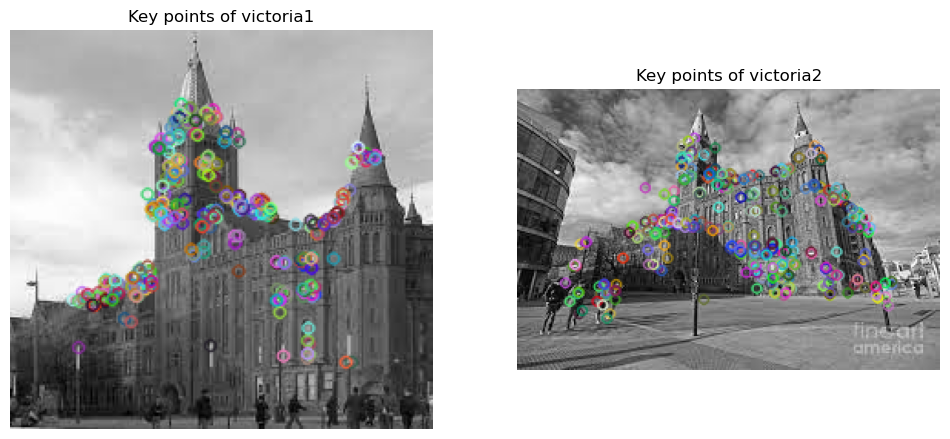

In [4]:
# Task2

# Part2: Extract ORB keypoints

# Load images in color
color_img1 = cv2.imread('image/victoria1.jpg')  
color_img2 = cv2.imread('image/victoria2.jpg')  
if color_img1 is None:
    raise FileNotFoundError("Image 'victoria1.jpg' not found")
if color_img2 is None:
    raise FileNotFoundError("Image 'victoria2.jpg' not found")

# Convert to grayscale for keypoint detection
img1 = cv2.cvtColor(color_img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(color_img2, cv2.COLOR_BGR2GRAY)

# Create an ORB detector
orb = cv2.ORB_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Check if any keypoints are found (ORB might fail to detect keypoints in very uniform images)
if len(keypoints1) == 0:
    print("No keypoints found in the first image.")
if len(keypoints2) == 0:
    print("No keypoints found in the second image.")

# Visualize keypoints on the color images
img1_keypoints = cv2.drawKeypoints(img1, keypoints1, color_img1, flags=0)
img2_keypoints = cv2.drawKeypoints(img2, keypoints2, color_img2, flags=0)

# Display the images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img1_keypoints, cmap='gray')
plt.title('Key points of victoria1')
plt.axis('off')

plt.subplot(122)
plt.imshow(img2_keypoints, cmap='gray')
plt.title('Key points of victoria2')
plt.axis('off')

plt.show()


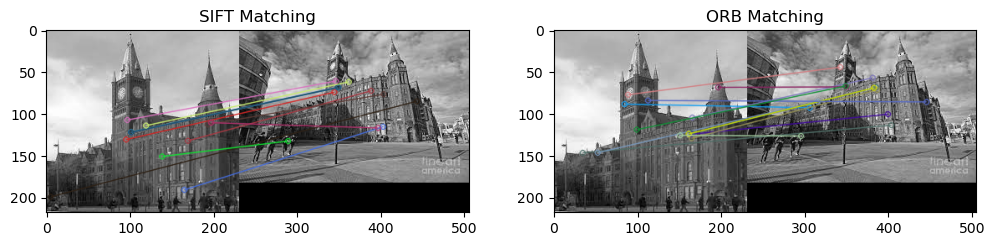

In [5]:
# Part3

# Load images
img1 = cv2.imread('image/victoria1.jpg')
img2 = cv2.imread('image/victoria2.jpg')

# Convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# --- SIFT Section ---
# Create a SIFT feature detector
sift = cv2.SIFT_create()

# Use SIFT to extract keypoints and descriptors
keypoints1_sift, descriptors1_sift = sift.detectAndCompute(img1_gray, None)
keypoints2_sift, descriptors2_sift = sift.detectAndCompute(img2_gray, None)

# Create a brute-force matcher
bf_sift = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True) 

# Perform SIFT feature matching
matches_sift = bf_sift.match(descriptors1_sift, descriptors2_sift)
matches_sift = sorted(matches_sift, key = lambda x: x.distance)

# Use ratio test to filter SIFT matches
bf_knn = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches_knn = bf_knn.knnMatch(descriptors1_sift, descriptors2_sift, k=2)

good_matches_sift = []
for m, n in matches_knn:
    if m.distance < 0.8 * n.distance: 
        good_matches_sift.append(m)

# Draw SIFT matching results
img_result_sift = cv2.drawMatches(img1_gray, keypoints1_sift, img2_gray, keypoints2_sift, good_matches_sift, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# --- ORB Section ---
# Create an ORB feature detector
orb = cv2.ORB_create()

# Use ORB to extract keypoints and descriptors
keypoints1_orb, descriptors1_orb = orb.detectAndCompute(img1_gray, None)
keypoints2_orb, descriptors2_orb = orb.detectAndCompute(img2_gray, None)

# Create a brute-force matcher with Hamming distance
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Perform ORB feature matching
matches_orb = bf_orb.match(descriptors1_orb, descriptors2_orb)
matches_orb = sorted(matches_orb, key = lambda x: x.distance)  # Sort by ascending distance

# Use ratio test to filter ORB matches
bf_knn_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
matches_knn_orb = bf_knn_orb.knnMatch(descriptors1_orb, descriptors2_orb, k=2)

good_matches_orb = []
for m, n in matches_knn_orb:
    if m.distance < 0.8 * n.distance:
        good_matches_orb.append(m)

# Draw ORB matching results
img_result_orb = cv2.drawMatches(img1_gray, keypoints1_orb, img2_gray, keypoints2_orb, good_matches_orb, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# --- Display Results ---
# Display SIFT and ORB matching results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_result_sift)
plt.title('SIFT Matching')

plt.subplot(1, 2, 2)
plt.imshow(img_result_orb)
plt.title('ORB Matching')

plt.show()
